In [1]:
#from pycaret.classification import *
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore')

**Column변경 **
> a_event: all event (event+other death), composite outcome+ other death 포함

> fat_ae: a_event의 duration에 해당

In [2]:
revised_columns=['ini_nih','hct','bun','fbs','wbc','cr','ldl','pre_good_mrs','age','END','fat_eod','fat_AE','A_event'] ##exclude other event variables

In [3]:
data= pd.read_csv('df_csv_merged_v2.1.csv')

In [4]:
data1=data[revised_columns]

In [5]:
data1.shape

(3340, 13)

In [6]:
data1.head()

,ini_nih,hct,bun,fbs,wbc,cr,ldl,pre_good_mrs,age,END,fat_eod,fat_AE,A_event
0,0,NaN,14.8,102.0,NaN,0.8,150.0,1.0,64,0.0,NaN,NaN,NaN
1,5,0.0,0.0,131.0,0.00,0.0,137.0,1.0,74,0.0,NaN,NaN,NaN
2,1,47.4,19.7,168.0,9.18,1.0,116.0,1.0,56,0.0,NaN,NaN,NaN
3,4,43.2,11.5,91.0,6.30,0.7,145.0,0.0,75,0.0,NaN,NaN,NaN
4,4,24.8,68.1,70.0,6.40,4.3,31.0,1.0,89,0.0,NaN,NaN,NaN


In [7]:
##fat_event null
pd.DataFrame(data1.isna().sum(axis=0).T)

,0
ini_nih,0
hct,1
bun,2
fbs,44
wbc,1
cr,2
ldl,80
pre_good_mrs,1
age,0
END,1


**Idea **

> IF event=0, save index and then value of fat_eod(duration) into fat_AE 

In [8]:
## save index 
survive_index=data1[data1['A_event']==0].index

In [9]:
len(survive_index)  ## 2946

1815

In [10]:
##list format
a=data1.loc[survive_index,'fat_eod']
a=a.to_list()
len(a)

1815

In [11]:
##해당하는 위치 index에 fat_eod list값 반환 
data1.loc[survive_index,'fat_AE']=a

In [12]:
##fat_event null
pd.DataFrame(data1.isna().sum(axis=0).T)

,0
ini_nih,0
hct,1
bun,2
fbs,44
wbc,1
cr,2
ldl,80
pre_good_mrs,1
age,0
END,1


### Reset data with only fat_AE (duration), A_event (event)

In [13]:
data1.shape

(3340, 13)

In [14]:
## drop rows(ID) who have missing value
data2=data1.dropna(axis=0,how='any',subset=['ini_nih','hct','bun','fbs','wbc','cr','ldl','pre_good_mrs','age','END'])

In [15]:
selected_columns=['ini_nih','hct','bun','fbs','wbc','cr','ldl','pre_good_mrs','age','END','A_event','fat_AE'] ##exclude other event variables

In [16]:
data2=data2[selected_columns]
data2.shape

(3215, 12)

In [17]:
## A_event has more missing values than a number of fat_AE (standard point)
data3=data2.dropna(axis=0,how='any',subset=['A_event'])

In [18]:
##fat_event null
pd.DataFrame(data3.isna().sum(axis=0).T)

,0
ini_nih,0
hct,0
bun,0
fbs,0
wbc,0
cr,0
ldl,0
pre_good_mrs,0
age,0
END,0


**Visualization**

In [19]:
import seaborn as sns

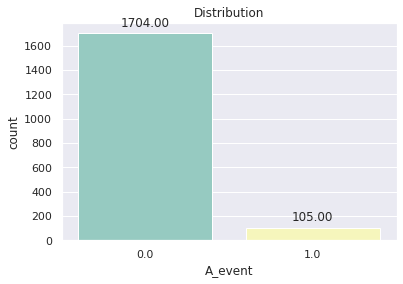

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [20]:
from matplotlib.pyplot import figure
sns.set_theme(style="darkgrid")
splot=sns.countplot(x="A_event",data=data3,palette="Set3")
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'),
               (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', 
               xytext = (0, 10), textcoords = 'offset points')
plt.rcParams["figure.figsize"] = (10,10)
plt.title("Distribution")
plt.show()
figure(figsize=(8, 6), dpi=80)

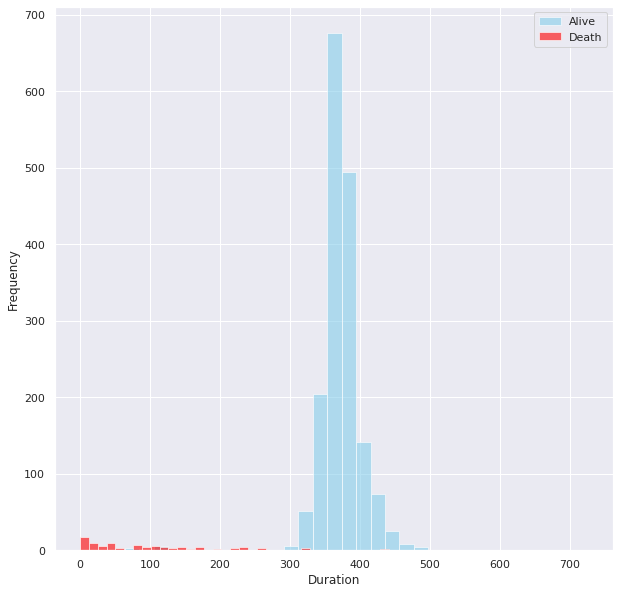

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [21]:
data3[data3['A_event'] == 0]['fat_AE'].hist(bins=35, color='skyblue', label='Alive', alpha=0.6)
data3[data3['A_event'] == 1]['fat_AE'].hist(bins=35, color='red', label='Death', alpha=0.6)
plt.legend()
plt.xlabel("Duration")
plt.ylabel("Frequency")
plt.show()
figure(figsize=(8, 6), dpi=80)

Standard methods in Survival Analysis
> 1. Kaplan Meier

In [313]:
columns_stratify=['ini_nih','hct','bun','fbs','wbc','cr','ldl','pre_good_mrs','age','END']
target=['A_event']

In [314]:
# splitting to X, y format
X = data3[columns_stratify]
y = data3[target]

In [315]:
# splitting between train, and validation 
(X_train, X_valid, y_train, y_valid) = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)
(X_valid, X_test, y_valid, y_test) = train_test_split(X_valid, y_valid, test_size=0.4, random_state=42,stratify=y_valid)

In [316]:
y_train_time=data3.loc[y_train.index,'fat_AE']
y_valid_time=data3.loc[y_valid.index,'fat_AE']
y_test_time=data3.loc[y_test.index,'fat_AE']

In [317]:
##DF 형태 변환
y_train_time=pd.DataFrame(y_train_time)
y_valid_time=pd.DataFrame(y_valid_time)
y_test_time=pd.DataFrame(y_test_time)

In [318]:
##time, event  concat
y_train=pd.concat([y_train,y_train_time],axis=1)
y_valid=pd.concat([y_valid,y_valid_time],axis=1)
y_test=pd.concat([y_test,y_test_time],axis=1)

In [319]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(y_train["fat_AE"], y_train["A_event"])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 1266 total observations, 1193 right-censored observations>

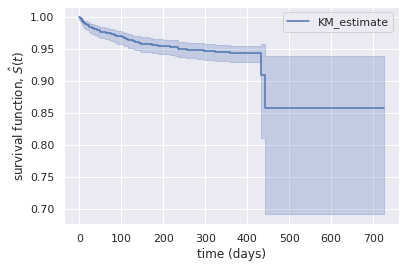

In [320]:
plot = kmf.plot_survival_function()
plot.set_xlabel('time (days)')
plot.set_ylabel('survival function, $\hat{S}(t)$')
plot

##### The estimated S(t) can be plotted as a stepwise function of overall population of individuals. As an example, in the plot below, it is clear that for time t=400days, the probability that borrowers survive beyond this time is about 85%

>2. Cox proportional hazards Model


*   Semi-parametric methods



In [322]:
data3.head()

,ini_nih,hct,bun,fbs,wbc,cr,ldl,pre_good_mrs,age,END,A_event,fat_AE
10,0,36.5,17.2,149.0,4.6,0.70,59.0,1.0,50,0.0,0.0,372.0
11,2,32.4,10.2,110.0,4.2,0.70,95.0,1.0,66,0.0,0.0,409.0
13,10,43.8,15.3,98.0,4.7,0.50,64.0,1.0,70,0.0,0.0,364.0
14,1,27.5,27.1,227.0,4.7,6.01,37.0,1.0,51,0.0,0.0,379.0
15,0,34.6,23.5,118.0,4.7,1.40,121.0,1.0,49,0.0,0.0,439.0


In [332]:
##Dummy coding
data4=pd.get_dummies(data3, drop_first=True,columns = ['ini_nih','pre_good_mrs','END'])

In [333]:
cols_standardize = ['hct', 'bun', 'fbs', 'wbc', 'cr','ldl','age','cr']  ## numeric 

In [334]:
## standard scaling for numeric values
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
data4[cols_standardize] = standardScaler.fit_transform(data4[cols_standardize])

In [335]:
data4.head()

,hct,bun,fbs,wbc,cr,ldl,age,A_event,fat_AE,ini_nih_1,ini_nih_2,ini_nih_3,ini_nih_4,ini_nih_5,ini_nih_6,ini_nih_7,ini_nih_8,ini_nih_9,ini_nih_10,ini_nih_11,ini_nih_12,ini_nih_13,ini_nih_14,ini_nih_15,ini_nih_16,ini_nih_17,ini_nih_18,ini_nih_19,ini_nih_20,ini_nih_21,ini_nih_22,ini_nih_23,ini_nih_25,ini_nih_28,ini_nih_29,pre_good_mrs_1.0,END_1.0
10,-0.489846,0.081322,0.407540,-1.162675,-0.257619,-1.364339,-1.472073,0.0,372.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
11,-0.939218,-0.901593,-0.321875,-1.307783,-0.257619,-0.406616,-0.180031,0.0,409.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
13,0.310256,-0.185469,-0.546310,-1.126398,-0.490414,-1.231321,0.142980,0.0,364.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
14,-1.476272,1.471445,1.866369,-1.126398,5.923088,-1.949613,-1.391321,0.0,379.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
15,-0.698091,0.965946,-0.172252,-1.126398,0.557164,0.285073,-1.552826,0.0,439.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation

cox = CoxPHFitter(penalizer=0.01)

#fitting
cox.fit(data4, duration_col='fat_AE', event_col='A_event', show_progress=True)
cox.print_summary()

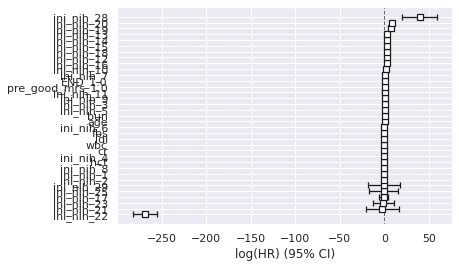

In [343]:
cox.plot()

In [346]:
target=['A_event']

In [349]:
# splitting to X, y format
X = data4.drop(columns=['A_event','fat_AE'],axis=1)
y = data4[target]

In [350]:
# splitting between train, and validation 
(X_train, X_valid, y_train, y_valid) = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)
(X_valid, X_test, y_valid, y_test) = train_test_split(X_valid, y_valid, test_size=0.4, random_state=42,stratify=y_valid)

In [353]:
y_train_time=data4.loc[y_train.index,'fat_AE']
y_valid_time=data4.loc[y_valid.index,'fat_AE']
y_test_time=data4.loc[y_test.index,'fat_AE']

In [354]:
##DF 형태 변환
y_train_time=pd.DataFrame(y_train_time)
y_valid_time=pd.DataFrame(y_valid_time)
y_test_time=pd.DataFrame(y_test_time)

In [355]:
##time, event  concat
y_train=pd.concat([y_train,y_train_time],axis=1)
y_valid=pd.concat([y_valid,y_valid_time],axis=1)
y_test=pd.concat([y_test,y_test_time],axis=1)

In [358]:
concat_data_x=pd.concat([X_train,y_train],axis=1)

In [360]:
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation

cox = CoxPHFitter(penalizer=0.01)

#fitting
cox_model=cox.fit(concat_data_x,duration_col='fat_AE', event_col='A_event', show_progress=True)
cox_model.print_summary()

Iteration 1: norm_delta = 2.83520, step_size = 0.9000, log_lik = -510.77987, newton_decrement = 148.91849, seconds_since_start = 0.1
Iteration 2: norm_delta = 96.91908, step_size = 0.9000, log_lik = -1543.57800, newton_decrement = 60145.53636, seconds_since_start = 0.2
Iteration 3: norm_delta = 13.74286, step_size = 0.0900, log_lik = -1407.21447, newton_decrement = 1340.78589, seconds_since_start = 0.3
Iteration 4: norm_delta = 13.31729, step_size = 0.0287, log_lik = -1331.45409, newton_decrement = 1248.18329, seconds_since_start = 0.3
Iteration 5: norm_delta = 13.14619, step_size = 0.0121, log_lik = -1301.40404, newton_decrement = 1212.71658, seconds_since_start = 0.4
Iteration 6: norm_delta = 13.07523, step_size = 0.0051, log_lik = -1289.02516, newton_decrement = 1198.27565, seconds_since_start = 0.5
Iteration 7: norm_delta = 13.04548, step_size = 0.0022, log_lik = -1283.84970, newton_decrement = 1192.26516, seconds_since_start = 0.6
Iteration 8: norm_delta = 13.03295, step_size = 0.

<lifelines.CoxPHFitter: fitted with 1266 total observations, 1193 right-censored observations>
             duration col = 'fat_AE'
                event col = 'A_event'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1266
number of events observed = 73
   partial log-likelihood = -1280.09
         time fit was run = 2022-01-27 07:38:45 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
hct                -0.11       0.89       0.19            -0.48             0.25                 0.62                 1.28
bun                 0.56       1.76       0.08             0.40             0.73                 1.49                 2.07
fbs                 0.34       1.41       0.13             0.09             0.59                 1.09                 1.81
wbc                 0.25       1.28       0.11             0.02             0.47                 1.02                 1.60
cr                  0.27       1.32       0.08             0.12             0.43                 1.13                 1.53
ldl                 0.16       1.17       0.16            -0.16             0.48                 0.85                 1.61
age                 0.39       1.48       0.16             0.07             0.72                 1.07                 2.05
ini_nih_1          -0.06       0.95       0.50            -1.04             0.93                 0.35                 2.54
ini_nih_2          -0.25       0.78       0.50            -1.22             0.72                 0.30                 2.06
ini_nih_3           0.16       1.18       0.75            -1.31             1.63                 0.27                 5.13
ini_nih_4          -0.17       0.84       0.82            -1.77             1.44                 0.17                 4.20
ini_nih_5           0.47       1.59       0.89            -1.28             2.21                 0.28                 9.14
ini_nih_6          -0.06       0.94       1.10            -2.23             2.10                 0.11                 8.18
ini_nih_7           0.77       2.16       0.97            -1.14             2.68                 0.32                14.52
ini_nih_8           0.34       1.40       0.85            -1.32             2.00                 0.27                 7.38
ini_nih_9           0.61       1.84       0.88            -1.11             2.33                 0.33                10.23
ini_nih_10          1.36       3.91       0.95            -0.50             3.23                 0.61                25.19
ini_nih_11          1.11       3.03       2.05            -2.91             5.12                 0.05               168.11
ini_nih_12          3.30      27.01       0.66             2.01             4.58                 7.48                97.62
ini_nih_13          3.93      51.15       0.81             2.34             5.53                10.38               251.96
ini_nih_14          4.39      80.47       0.62             3.17             5.61                23.79               272.18
ini_nih_15          3.03      20.67       0.71             1.64             4.41                 5.17                82.64
ini_nih_16          3.28      26.53       0.68             1.94             4.62                 6.94               101.42
ini_nih_17         -0.87       0.42       3.09            -6.93             5.19                 0.00               179.67
ini_nih_18          2.71      15.05       1.82            -0.85             6.27                 0.43               527.93
ini_nih_19          8.14    3443.68       0.53             7.11             9.18              1226.36              9670.03
ini_nih_20         -0.59       0.56       9.04           -18.32            17.14                 0.00             2.77e+07
ini_

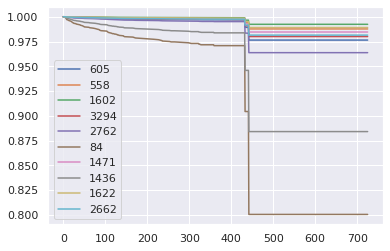

In [366]:
# Plot the survival function :
d_data = X_test.iloc[0:10,:]
cox_model.predict_survival_function(d_data).plot()

In [367]:
# predicting
cox_model.concordance_index_

0.765004499619263

# ML Surivival
>Random survival forests

https://square.github.io/pysurvival/models/random_survival_forest.html

In [409]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from pysurvival.models.simulations import SimulationModel
from pysurvival.models.survival_forest import RandomSurvivalForestModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [373]:
concat_data_x=pd.concat([X_train,y_train],axis=1)

In [374]:
T_train, T_test = y_train['fat_AE'].values, y_valid['fat_AE'].values
E_train, E_test = y_train['A_event'].values, y_valid['A_event'].values

In [375]:
#### Creating an instance of the Conditional model and fitting the data.
# Building the model
rsf = RandomSurvivalForestModel(num_trees=200)
rsf.fit(X_train, T_train, E_train,
        max_features="sqrt", max_depth=5, min_node_size=20)

RandomSurvivalForestModel

In [376]:
####- Cross Validation / Model Performances
c_index = concordance_index(rsf, X_valid, T_test, E_test) #0.68
print('C-index: {:.2f}'.format(c_index))

C-index: 0.68


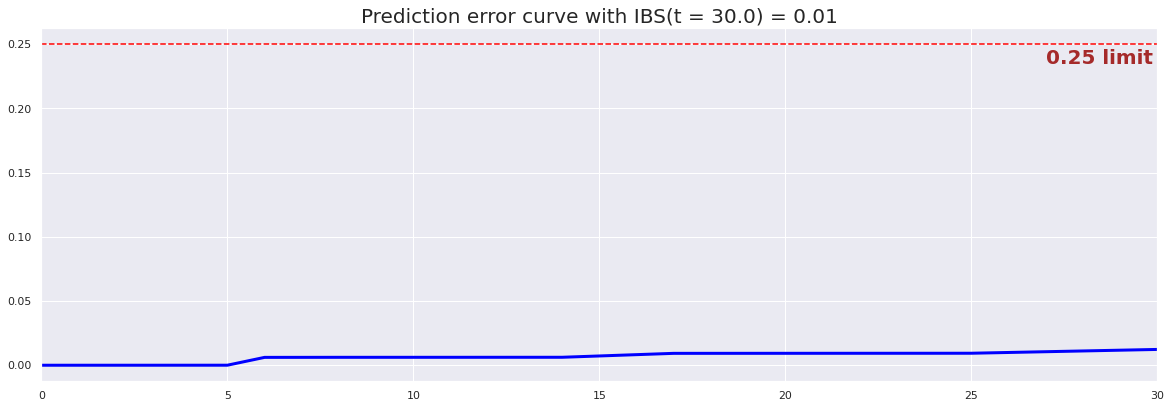

IBS: 0.01


In [377]:
ibs = integrated_brier_score(rsf, X_valid, T_test, E_test, t_max=30,
            figure_size=(20, 6.5) )   ## 0.006805980046706943
print('IBS: {:.2f}'.format(ibs))

# Deep Learning Surivival
> Cox-PH DeepSurv


In [124]:
pip install torchtuples

     |████████████████████████████████| 41 kB 329 kB/s 


In [126]:
pip install pycox

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

In [128]:
np.random.seed(1234)
_ = torch.manual_seed(123)

df_train, df_test,df_val

In [142]:
columns_stratify=['ini_nih','hct','bun','fbs','wbc','cr','ldl','pre_good_mrs','age','END']
target=['A_event']

In [385]:
# splitting to X, y format
X = data3[columns_stratify]
y = data3[target]

In [386]:
# splitting between train, and validation 
(X_train, X_valid, y_train, y_valid) = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)
(X_valid, X_test, y_valid, y_test) = train_test_split(X_valid, y_valid, test_size=0.4, random_state=42,stratify=y_valid)

In [199]:
data3.tail()

,ini_nih,hct,bun,fbs,wbc,cr,ldl,pre_good_mrs,age,END,A_event,fat_AE
3328,3,41.30,29.8,84.0,10.9,1.1,111.0,1.0,82,0.0,0.0,423.0
3330,3,37.40,15.2,205.0,5.9,0.5,130.0,1.0,61,0.0,0.0,415.0
3333,2,1.12,13.8,91.0,9.2,0.4,113.0,1.0,50,0.0,0.0,385.0
3334,0,45.60,9.6,100.0,6.4,0.7,111.0,1.0,37,0.0,0.0,404.0
3336,6,39.40,14.7,121.0,9.3,0.8,193.0,1.0,80,1.0,0.0,361.0


In [387]:
### X데이터 셋 standardize -> numpy array 형태로 
cols_standardize = ['hct', 'bun', 'fbs', 'wbc', 'cr','ldl','age','cr']  ## numeric 
cols_leave = ['ini_nih', 'END'] ## category

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [388]:
x_train = x_mapper.fit_transform(X_train).astype('float32')
x_val = x_mapper.transform(X_valid).astype('float32')
x_test = x_mapper.transform(X_test).astype('float32')

In [389]:
y_train_time=data3.loc[y_train.index,'fat_AE']
y_valid_time=data3.loc[y_valid.index,'fat_AE']
y_test_time=data3.loc[y_test.index,'fat_AE']

In [390]:
##DF 형태 변환
y_train_time=pd.DataFrame(y_train_time)
y_valid_time=pd.DataFrame(y_valid_time)
y_test_time=pd.DataFrame(y_test_time)

In [391]:
##time, event  concat
y_train=pd.concat([y_train,y_train_time],axis=1)
y_valid=pd.concat([y_valid,y_valid_time],axis=1)
y_test=pd.concat([y_test,y_test_time],axis=1)

In [392]:
get_target = lambda x: (x['fat_AE'].values, x['A_event'].values)
y_train = get_target(y_train)
y_val = get_target(y_valid)
durations_test, events_test = get_target(y_test)
val = x_val, y_val

In [224]:
y_train

(array([367., 377., 369., ..., 371., 376., 324.]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [226]:
in_features = X_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

In [227]:
model = CoxPH(net, tt.optim.Adam)

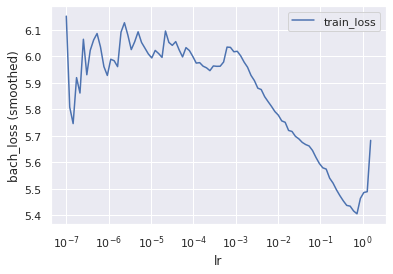

In [228]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [229]:
lrfinder.get_best_lr() #0.07390722033525823  

0.07390722033525823

In [230]:
model.optimizer.set_lr(0.01)

In [233]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [234]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

18:	[0s / 0s],		train_loss: 4.5930,	val_loss: 4.9019
19:	[0s / 0s],		train_loss: 4.4525,	val_loss: 4.9335
20:	[0s / 0s],		train_loss: 4.4532,	val_loss: 4.9831
21:	[0s / 0s],		train_loss: 4.3718,	val_loss: 5.0399
22:	[0s / 0s],		train_loss: 4.4531,	val_loss: 5.1394
23:	[0s / 0s],		train_loss: 4.4114,	val_loss: 5.0904
24:	[0s / 0s],		train_loss: 4.3697,	val_loss: 5.0740
25:	[0s / 0s],		train_loss: 4.3122,	val_loss: 5.1147
26:	[0s / 0s],		train_loss: 4.2607,	val_loss: 5.0849
27:	[0s / 0s],		train_loss: 4.3763,	val_loss: 5.0988
28:	[0s / 0s],		train_loss: 4.1964,	val_loss: 5.2045
CPU times: user 335 ms, sys: 6.04 ms, total: 341 ms
Wall time: 367 ms


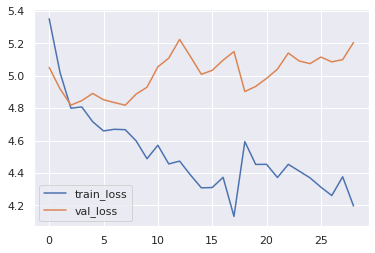

In [235]:
_ = log.plot()

In [236]:
model.partial_log_likelihood(*val).mean() ## -5.609597682952881

-5.609597682952881

In [237]:
_ = model.compute_baseline_hazards()

In [238]:
_

duration
0.0      0.000428
1.0      0.000428
2.0      0.000000
3.0      0.000429
4.0      0.000435
           ...   
468.0    0.000000
473.0    0.000000
476.0    0.000000
481.0    0.000000
725.0    0.000000
Name: baseline_hazards, Length: 202, dtype: float64

In [240]:
surv = model.predict_surv_df(x_test)

In [311]:
y_test.max()

A_event      1.0
fat_AE     534.0
dtype: float64

In [312]:
y_test.mean()

A_event      0.059633
fat_AE     359.151376
dtype: float64

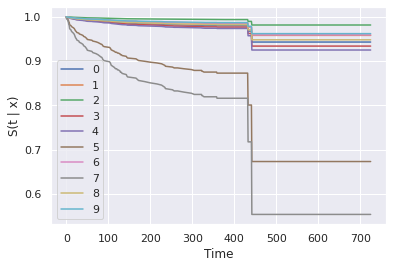

In [247]:
surv.iloc[:, :10].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [242]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [243]:
ev.concordance_td() ## 0.5967682702901211

0.5967682702901211

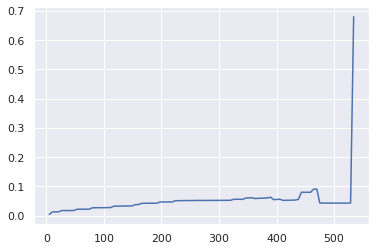

In [244]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [245]:
ev.integrated_brier_score(time_grid)

0.04804608192116522

In [246]:
ev.integrated_nbll(time_grid)

0.1995778672186549

2차시도

In [395]:
in_features = X_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

In [396]:
model2= CoxPH(net, tt.optim.Adam)

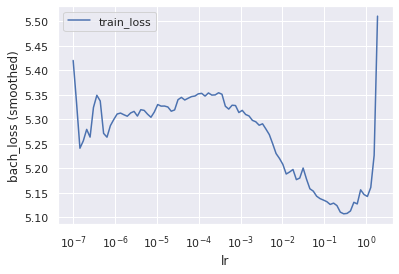

In [397]:
batch_size = 256
lrfinder = model2.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [398]:
lrfinder.get_best_lr()

0.029150530628251937

In [399]:
model2.optimizer.set_lr(0.029150530628251937)

In [400]:
epochs = 300
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [401]:
%%time
log = model2.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 5.1850,	val_loss: 4.6788
1:	[0s / 0s],		train_loss: 4.9545,	val_loss: 4.6493
2:	[0s / 0s],		train_loss: 4.6756,	val_loss: 5.0354
3:	[0s / 0s],		train_loss: 4.5973,	val_loss: 4.7600
4:	[0s / 0s],		train_loss: 4.6974,	val_loss: 4.7132
5:	[0s / 0s],		train_loss: 4.4542,	val_loss: 4.8642
6:	[0s / 0s],		train_loss: 4.5205,	val_loss: 4.7252
7:	[0s / 0s],		train_loss: 4.4307,	val_loss: 4.7129
8:	[0s / 0s],		train_loss: 4.5372,	val_loss: 4.7802
9:	[0s / 0s],		train_loss: 4.2517,	val_loss: 4.8170
10:	[0s / 0s],		train_loss: 4.2334,	val_loss: 5.0752
11:	[0s / 0s],		train_loss: 4.3073,	val_loss: 5.0161
CPU times: user 254 ms, sys: 1.87 ms, total: 255 ms
Wall time: 254 ms


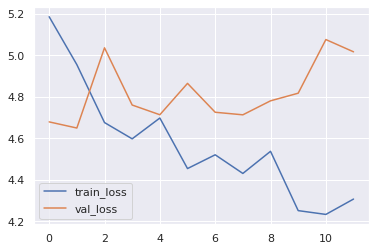

In [402]:
_ = log.plot()

In [403]:
model2.partial_log_likelihood(*val).mean()

-5.4723639488220215

In [404]:
_ = model2.compute_baseline_hazards()

In [405]:
surv = model2.predict_surv_df(x_test)

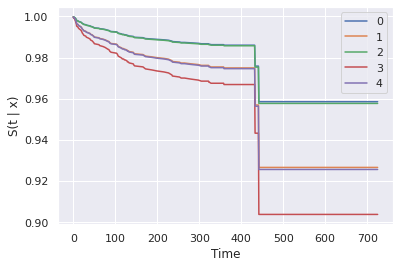

In [406]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [407]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [408]:
ev.concordance_td() ## 0.596401028277635

0.596401028277635